In [1]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import imageio
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.dataset import random_split
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import TwoSlopeNorm
import random

In [2]:
def process_elevation_data(file_id):
    """
    Processes elevation data from a DEM file.

    Args:
    file_id (str): Identifier of the DEM file to be processed.

    Returns:
    torch.Tensor: A tensor combining the original elevation data and its slope in x and y directions.
    """
    try:
        file_path = f'DEM_{file_id}.txt'

        elevation_data = np.loadtxt(file_path)
        elevation_grid = elevation_data[:, 2].reshape(64, 64)
        elevation_tensor = torch.tensor(elevation_grid, dtype=torch.float32)
        slope_x, slope_y = torch.gradient(elevation_tensor)
        elevation_slope_tensor = torch.stack((elevation_tensor, slope_x, slope_y), dim=0)

        return elevation_slope_tensor

    except Exception as e:
        print(f"Error processing elevation data: {e}")
        return None


In [3]:
def process_water_depth(file_id, time_step=0):
    """
    Processes water depth data from a specific time step in a file.

    Args:
    file_id (str): Identifier of the water depth file to be processed.
    time_step (int): Time step to extract from the file. Default is the first time step.

    Returns:
    torch.Tensor or None: A 64x64 tensor representing water depth at the given time step, or None if the data is invalid.
    """
    file_path = f'WD_{file_id}.txt'

    # Read the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    try:
        # Extract the specified row and convert string elements to floats
        selected_row = lines[time_step].split()
        depth_values = [float(val) for val in selected_row]

        # Validate and reshape the data into a 64x64 tensor
        if len(depth_values) == 64 * 64:
            depth_tensor = torch.tensor(depth_values).view(64, 64)
            return depth_tensor
        else:
            raise ValueError(f"The number of elements in {file_path} at time step {time_step} doesn't match a 64x64 matrix.")
    except IndexError:
        raise IndexError(f"Time step {time_step} is out of range for the file {file_path}.")

# Creating Train Dataset

In [4]:
# Specify the time t0 and t
t0 = 0
t = 1

train_dataset = []

for i in range(1, 81):  # Loop through file IDs from DEM_1 to DEM_80
    file_id = i
    
    # Input Tensor (input_tensor.shape will be [4, 64, 64])
    elevation_slope_tensor = process_elevation_data(file_id)
    water_depth_input_tensor = process_water_depth(file_id, time_step=t0)  # Time Step is t0
    water_depth_input_tensor = torch.unsqueeze(water_depth_input_tensor, 0)
    
    input_tensor = torch.cat((elevation_slope_tensor, water_depth_input_tensor), dim=0)
    input_tensor = input_tensor.double()
    
    # Output Sequence Tensor (output_sequence_tensor.shape will be [48, 64, 64])
    output_tensors = []
    for time_step_index in range(1, 96, 2):  # Loop through every even time step out of the 96
        water_depth_output_tensor = process_water_depth(file_id, time_step=t0 + time_step_index)
        output_tensors.append(water_depth_output_tensor)
    
    output_sequence_tensor = torch.stack(output_tensors, dim=0)
    output_sequence_tensor = output_sequence_tensor.double()
    
    # Create a tuple
    train_dataset_sample = (input_tensor, output_sequence_tensor)
    
    # Append the sample to the train_dataset list
    train_dataset.append(train_dataset_sample)


In [5]:
# Printing a few samples to verify the shape of train input and output tensors

for i, sample in enumerate(train_dataset[:5]):  # Print shapes for the first 5 samples
    input_train_tensor, output_train_sequence_tensor = sample
    
    print(f"Sample {i+1}:")
    print("Input Train Tensor Shape:", input_train_tensor.shape)
    print("Output Train Sequence Tensor Shape:", output_train_sequence_tensor.shape)
    print()


Sample 1:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 2:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 3:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 4:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 5:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])



In [6]:
# # Select a random sample from the dataset
# sample_index = random.randint(0, len(train_dataset) - 1)
# print(sample_index)
# input_tensor, output_sequence_tensor = train_dataset[sample_index]

# # Plot input tensors (DEM, slope x, slope y, water depth at initial time step)
# fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# # Plot DEM (Terrain) with appropriate colormap
# axs[0].imshow(input_tensor[0], cmap='terrain')
# axs[0].set_title('DEM (Terrain)')

# # Plot slope x and slope y with 'coolwarm' colormap
# for i in range(1, 3):
#     axs[i].imshow(input_tensor[i], cmap='coolwarm')
#     axs[i].set_title(f'Slope {"X" if i == 1 else "Y"}')

# # Plot water depth at initial time step and output at a random time step with 'Blues' colormap
# axs[3].imshow(input_tensor[3], cmap='Blues')
# axs[3].set_title('Water Depth (Initial Time Step)')

# # Select a random time step from the output sequence tensor
# random_time_step = random.randint(0, output_sequence_tensor.shape[0] - 1)
# output_at_time_step = output_sequence_tensor[random_time_step]

# # Plot the output at the random time step
# axs[4].imshow(output_at_time_step, cmap='Blues')
# axs[4].set_title(f'Output at Time Step {random_time_step}')

# plt.tight_layout()
# plt.show()


# Creating the Test Dataset

In [7]:
# Specify the time t0 and t
t0 = 0
t = 1

# Loop through file IDs from DEM_1 to DEM_80
test_dataset = []

for i in range(500, 520):  # Assuming file IDs are numbered from 1 to 80
    file_id = i
    
    # Input Tensor (input_tensor.shape will be [4, 64, 64])
    elevation_slope_tensor = process_elevation_data(file_id)
    water_depth_input_tensor = process_water_depth(file_id, time_step=t0)  # Time Step is t0
    # Add an extra dimension to make water_depth_tensor [1, 64, 64]
    water_depth_input_tensor = torch.unsqueeze(water_depth_input_tensor, 0)
    
    # Concatenate to create the input tensor
    input_test_tensor = torch.cat((elevation_slope_tensor, water_depth_input_tensor), dim=0)
    input_test_tensor = input_test_tensor.double()
    
    # Output Sequence Tensor (output_sequence_tensor.shape will be [48, 64, 64])
    output_test_tensors = []
    for time_step_index in range(1,96,2):  # Loop through every even time step out of the 96
        water_depth_output_tensor = process_water_depth(file_id, time_step=t0 + time_step_index)
        output_test_tensors.append(water_depth_output_tensor)
    
    # Stack the list of output tensors along the new time dimension to create a sequence
    output_test_sequence_tensor = torch.stack(output_test_tensors, dim=0)
    output_test_sequence_tensor = output_test_sequence_tensor.double()
    
    # Create a tuple
    test_dataset_sample = (input_test_tensor, output_test_sequence_tensor)
    
    # Append the sample to the test_dataset list
    test_dataset.append(test_dataset_sample)


In [8]:
# Printing a few samples to verify the shape of test input and output tensors

for i, sample in enumerate(test_dataset[:5]):  # Print shapes for the first 5 samples
    input_test_tensor, output_test_sequence_tensor = sample
    
    print(f"Sample {i+1}:")
    print("Input Test Tensor Shape:", input_test_tensor.shape)
    print("Output Test Sequence Tensor Shape:", output_test_sequence_tensor.shape)
    print()


Sample 1:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 2:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 3:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 4:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 5:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])



In [9]:
# # Select a random sample from the dataset
# sample_index = random.randint(0, len(test_dataset) - 1)
# input_test_tensor, output_test_sequence_tensor = test_dataset[sample_index]

# # Plot input tensors (DEM, slope x, slope y, water depth at initial time step)
# fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# # Plot DEM (Terrain) with appropriate colormap
# axs[0].imshow(input_tensor[0], cmap='terrain')
# axs[0].set_title('DEM (Terrain)')

# # Plot slope x and slope y with 'coolwarm' colormap
# for i in range(1, 3):
#     axs[i].imshow(input_test_tensor[i], cmap='coolwarm')
#     axs[i].set_title(f'Slope {"X" if i == 1 else "Y"}')

# # Plot water depth at initial time step and output at a random time step with 'Blues' colormap
# axs[3].imshow(input_test_tensor[3], cmap='Blues')
# axs[3].set_title('Water Depth (Initial Time Step)')

# # Select a random time step from the output sequence tensor
# random_time_step = random.randint(0, output_sequence_tensor.shape[0] - 1)
# output_test_at_time_step = output_test_sequence_tensor[random_time_step]

# # Plot the output at the random time step
# axs[4].imshow(output_test_at_time_step, cmap='Blues')
# axs[4].set_title(f'Output at Time Step {random_time_step}')

# plt.tight_layout()
# plt.show()


# Normalizing the Datasets

In [10]:
# def normalize_dataset(dataset, scaler_x, scaler_y):
#     # Extract min and max values from the scalers for inputs and outputs
#     min_x, max_x = scaler_x.data_min_[0], scaler_x.data_max_[0]
#     min_y, max_y = scaler_y.data_min_[0], scaler_y.data_max_[0]

#     normalized_dataset = []
#     for idx in range(len(dataset)):
#         x = dataset[idx][0]
#         y_sequence = dataset[idx][1]

#         # Normalize input (assuming it's a single tensor)
#         norm_x = (x - min_x) / (max_x - min_x)

#         # Normalize each output sequence tensor individually
#         normalized_sequence = []
#         for t in range(y_sequence.shape[0]):
#             norm_y = (y_sequence[t] - min_y) / (max_y - min_y)
#             normalized_sequence.append(norm_y)

#         normalized_dataset.append((norm_x, torch.stack(normalized_sequence)))

#     return normalized_dataset


In [11]:
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

# # Fit the scalers using the training dataset
# for idx in range(len(train_dataset)):
#     scaler_x.partial_fit(train_dataset[idx][0].flatten().unsqueeze(0).T.cpu())
#     scaler_y.partial_fit(train_dataset[idx][1].flatten().unsqueeze(0).T.cpu())

# # Normalize the datasets
# normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_y)
# normalized_test_dataset = normalize_dataset(test_dataset, scaler_x, scaler_y)


In [12]:
# # Assuming normalized_train_dataset and normalized_test_dataset are your normalized datasets

# # Print the minimum and maximum values for input and output sequences in the first sample of the normalized training dataset
# input_sample, output_sample = normalized_train_dataset[0]
# print("Input Min-Max:", input_sample[0].min().item(), "-", input_sample[0].max().item())
# print("Output Min-Max:", output_sample.min().item(), "-", output_sample.max().item())


# Splitting the Datasets

In [13]:
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Model

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the CNN architecture

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels=1, out_channels=1, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=48, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 128))
        self.down1 = (Down(128, 256))
        self.down2 = (Down(256, 512))
        self.down3 = (Down(512, 1024))
        factor = 2 if bilinear else 1
        self.down4 = (Down(1024, 2048 // factor))
        self.up1 = (Up(2048, 1024 // factor, bilinear))
        self.up2 = (Up(1024, 512 // factor, bilinear))
        self.up3 = (Up(512, 256 // factor, bilinear))
        self.up4 = (Up(256, 128, bilinear))
        self.outc = (OutConv(128, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Instantiate the CNN
model = UNet().to(device)  # Replace with your model and number of classes
summary(model, input_size=(4, 64, 64)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           4,608
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]         147,456
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              ReLU-6          [-1, 128, 64, 64]               0
        DoubleConv-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         294,912
      BatchNorm2d-10          [-1, 256, 32, 32]             512
             ReLU-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]         589,824
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

In [15]:
def train_epoch(model, loader, optimizer, device='cpu'):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0]
        y = batch[1]
        x, y = x.float().to(device), y.float().to(device)

        # Model prediction
        preds = model(x)

        # MSE loss function
        loss = nn.MSELoss()(preds, y)

        losses.append(loss.cpu().detach())

        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses

In [16]:
def evaluation(model, loader, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    losses = []

    with torch.no_grad():
        for batch in loader:
            x = batch[0]
            y = batch[1]
            x, y = x.float().to(device), y.float().to(device)

            # Model prediction
            preds = model(x)

            # MSE loss function
            loss = nn.MSELoss()(preds, y)
            losses.append(loss.cpu().detach())

    losses = np.array(losses).mean()

    return losses

In [17]:
# Set training parameters
learning_rate = 0.001
batch_size = 64
num_epochs = 100

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    # Training loop
    train_loss = train_epoch(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)

    # Validation loop
    validation_loss = evaluation(model, val_loader, device=device)
    validation_losses.append(validation_loss)

    # Print the loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Validation Loss: {validation_loss:.4f}')


Epoch 10 | Train Loss: 0.0718 | Validation Loss: 19775.9238
Epoch 20 | Train Loss: 0.0342 | Validation Loss: 207.6925
Epoch 30 | Train Loss: 0.0235 | Validation Loss: 1.6339
Epoch 40 | Train Loss: 0.0176 | Validation Loss: 0.0365
Epoch 50 | Train Loss: 0.0141 | Validation Loss: 0.0292
Epoch 60 | Train Loss: 0.0118 | Validation Loss: 0.0270
Epoch 70 | Train Loss: 0.0095 | Validation Loss: 0.0274
Epoch 80 | Train Loss: 0.0086 | Validation Loss: 0.0254
Epoch 90 | Train Loss: 0.0067 | Validation Loss: 0.0252
Epoch 100 | Train Loss: 0.0058 | Validation Loss: 0.0232


In [19]:
test_loss = evaluation(model, test_loader, device=device)
print(test_loss)

0.03374125


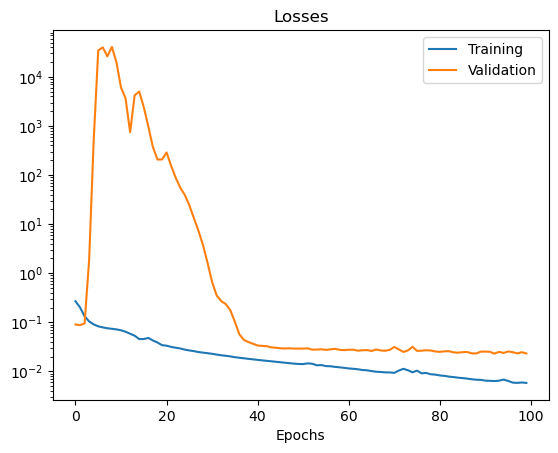

In [20]:
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [34]:
# select one sample
data_id = 2

x = test_dataset[data_id][0].unsqueeze(0)
x = x.float().to(device)
WD = test_dataset[data_id][1]

# Display the shapes of the input data and water depth tensor
print(f"Shape of input data (x): {x.shape}")
print(f"Shape of water depth (WD): {WD.shape}")

Shape of input data (x): torch.Size([1, 4, 64, 64])
Shape of water depth (WD): torch.Size([48, 64, 64])


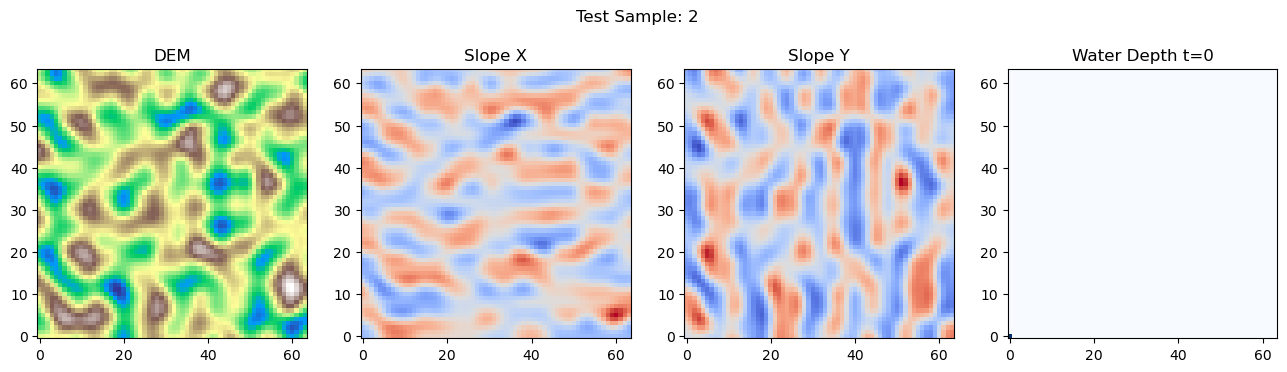

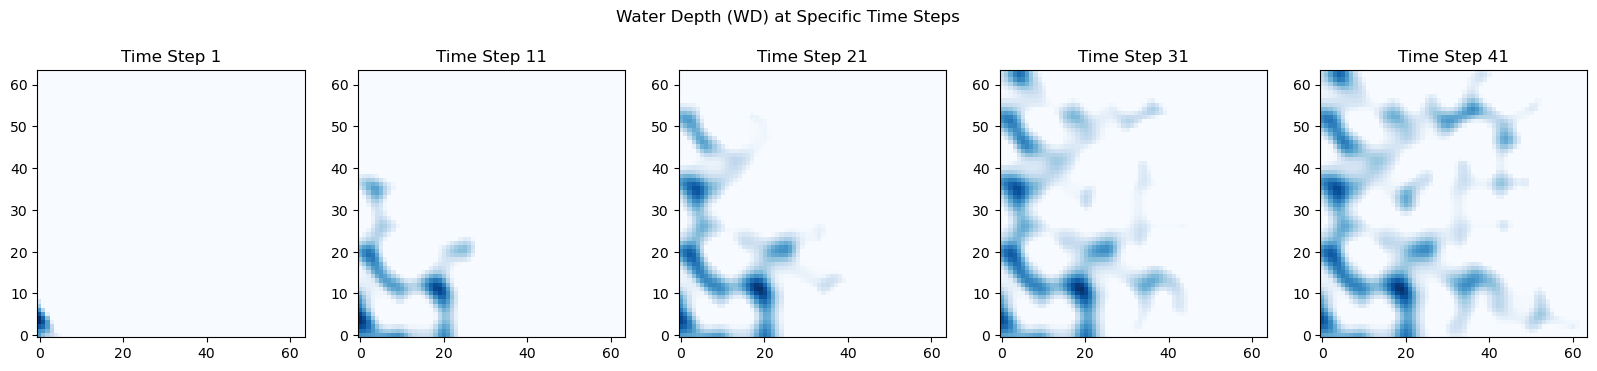

In [38]:
# Assuming the first plot represents terrain, and the subsequent plots use different colormaps
colormaps = ['terrain', 'coolwarm', 'coolwarm', 'Blues']

# Define titles for each channel
channel_titles = ['DEM', 'Slope X', 'Slope Y', f'Water Depth t={t0}']

# Plotting the input tensor (x)
x_np = x.squeeze(0).cpu().numpy()  # Convert tensor to NumPy array and remove the batch dimension
num_channels = x_np.shape[0]  # Number of channels in the input

# Plot each channel separately with different colormaps and titles
fig, axs = plt.subplots(1, num_channels, figsize=(4 * num_channels, 4))
for i in range(num_channels):
    axs[i].imshow(x_np[i], cmap=colormaps[i], origin='lower')  # Set origin to lower left and use different colormaps
    axs[i].set_title(channel_titles[i])  # Set individual titles for each channel
plt.suptitle(f'Test Sample: {data_id}')
plt.show()



# Plotting the WD tensor
WD_np = WD.cpu().numpy()  # Convert tensor to NumPy array

# Assuming WD is a sequence of images (96 time steps)
num_time_steps = WD_np.shape[0]

# Plotting specific time steps (e.g., every 10th time step)
time_steps_to_plot = list(range(0, num_time_steps, 10))

fig, axs = plt.subplots(1, len(time_steps_to_plot), figsize=(4 * len(time_steps_to_plot), 4))
for i, timestep in enumerate(time_steps_to_plot):
    axs[i].imshow(WD_np[timestep], cmap='Blues', origin='lower')  # Set origin to lower left
    axs[i].set_title(f"Time Step {timestep + 1}")
plt.suptitle("Water Depth (WD) at Specific Time Steps")
plt.show()



In [23]:
# predict the WD
pred_WD = model(x).detach()

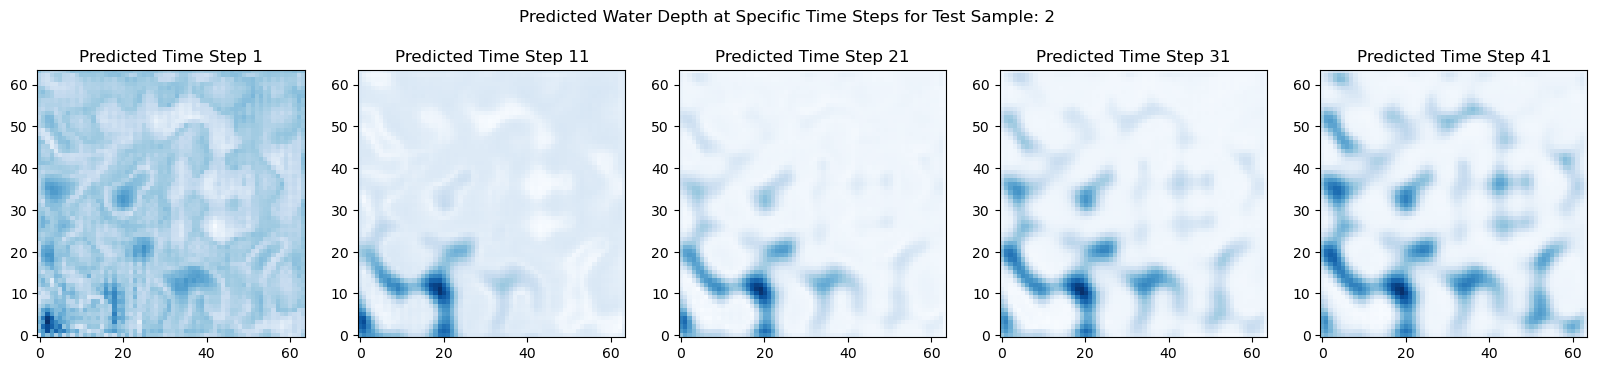

In [39]:
# Convert the predicted tensor to numpy array
pred_WD_np = pred_WD.squeeze(0).cpu().numpy()  # Assuming batch dimension needs to be squeezed

# Plotting specific time steps (e.g., every 10th time step)
time_steps_to_plot_pred = list(range(0, pred_WD_np.shape[0], 10))

fig, axs = plt.subplots(1, len(time_steps_to_plot_pred), figsize=(4 * len(time_steps_to_plot_pred), 4))
for i, timestep in enumerate(time_steps_to_plot_pred):
    axs[i].imshow(pred_WD_np[timestep], cmap='Blues', origin='lower')  # Assuming 'viridis' colormap, change as needed
    axs[i].set_title(f"Predicted Time Step {timestep + 1}")
plt.suptitle(f'Predicted Water Depth at Specific Time Steps for Test Sample: {data_id}')
plt.show()



In [25]:
# # Reshaping for the case of 96 timesteps
# DEM = scaler_x.inverse_transform(x[0].reshape(4, -1).T.cpu())[:, 0].reshape(64, 64)
# real_WD = scaler_y.inverse_transform(WD.reshape(96, -1).cpu()).reshape(96, 64, 64)
# pred_WD = scaler_y.inverse_transform(pred_WD.reshape(96, -1).cpu()).reshape(96, 64, 64)


In [26]:
# import matplotlib.pyplot as plt

# # Assuming pred_WD contains the predicted water depths with shape (96, 64, 64)
# num_time_steps = 4  # Number of time steps to plot

# fig, axs = plt.subplots(1, num_time_steps, figsize=(12, 3))

# for i in range(num_time_steps):
#     axs[i].imshow(pred_WD[i], cmap='viridis')  # Adjust the colormap as needed
#     axs[i].set_title(f"Time Step {i+1}")

# plt.tight_layout()
# plt.show()


In [27]:
# import matplotlib.pyplot as plt

# # Assuming pred_WD contains the predicted water depths with shape (96, 64, 64)
# num_time_steps = 50  # Number of time steps to plot
# sample_index = 0  # Index of the sample to visualize

# fig, axs = plt.subplots(5, 10, figsize=(15, 8))

# for i in range(5):
#     for j in range(10):
#         timestep = i * 10 + j
#         if timestep < num_time_steps:
#             axs[i, j].imshow(pred_WD[timestep], cmap='viridis')  # Adjust the colormap as needed
#             axs[i, j].set_title(f"Time Step {timestep + 1}")

# plt.tight_layout()
# plt.show()
